# HW11 - Descriptive Notebook

Note: Updated, to remove flattening in trainer function.

In this homework notebook, we will create a Wasserstein GAN with Convolution and Transpose Convolution layers, to be used on the MNIST dataset.

Get familiar with the code and write a small report (2 pages max), with answers to the questions listed at the end of the notebook.

**The report must be submitted in PDF format, before April 18th, 11.59pm!**

Do not forget to write your name and student ID on the report.

You may also submit your own copy of the notebook along with the report. If you do so, please add your name and ID to the cell below.

In [46]:
# Name: Gabriel Koh 
# Student ID: 1003882

### Imports needed

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch import Tensor
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import save_image
from torchvision.datasets import MNIST

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Dataset and dataloader

In [4]:
# Image transform to be applied to dataset
# - Tensor conversion
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

In [6]:
# MNIST train dataset
mnist = MNIST(root = './data/', train=True, download=True, transform=transform)
# mnist = torchvision.datasets.MNIST(root = './data/',
#                                    train = True,
#                                    transform = transform,
#                                    download = True)

In [7]:
# Data loader
batch_size = 32
data_loader = torch.utils.data.DataLoader(dataset = mnist,
                                          batch_size = batch_size, 
                                          shuffle = True)

### Critic model as a set of Conv2d layers

**Task1:** Rewrite the Critic model below, so that it uses Conv2d layers instead of fully connected ones shown in class.

You may look for inspiration in the encoder models used in Notebook 3 (W11S1 lecture).

The critic should use three Conv2d layers with progressive downsampling.

We do not advise to add more layers to the mix (BatchNorm, Dropout, etc.).

In [8]:
# Critic
class Critic(nn.Module):
    
    def __init__(self, image_size):
        """
        Only forced parameter will be the image size, set to 28.
        """
        super().__init__()
        self.image_size = image_size
        self.D = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride = 2, padding = 1),
            nn.Conv2d(16, 32, 3, stride = 2, padding = 1),
            nn.Conv2d(32, 64, 1, stride = 2, padding = 1)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(32*64*5*5, 32)
        )
        
    def forward(self, x):
        x = self.D(x)
        x = x.view(-1, 32*64*5*5)
        x = self.fc(x)
        x = x.view(-1, 1)
        return x

### Generator model as a set of Transposed Conv2d layers

**Task2:** Rewrite the Generator model below, so that it uses Transposed Conv2d layers instead of fully connected ones shown in class.

You may look for inspiration in the encoder models used in Notebooks 2 and 3 (W11S1 lecture).

The critic should use three Transposed Conv2d layers with progressive upsampling.

We do not advise to add more layers to the mix (BatchNorm, Dropout, etc.).

In [9]:
# Generator
class Generator(nn.Module):
    
    def __init__(self, latent_size, image_size):
        """
        Only forced parameters will be the image size, set to 28,
        and the latent size set to 64.
        """
        super().__init__()
        self.image_size = image_size
        self.latent_size = latent_size
        self.input_length = int(latent_size**0.5)
        self.fc = nn.Linear(latent_size, latent_size)
        self.G = nn.Sequential(
            nn.ConvTranspose2d(1, 4, 3,stride=1, padding=1),
            nn.ConvTranspose2d(4, 8, 3,stride=2, padding=1),
            nn.ConvTranspose2d(8, 1, 2,stride=2, padding=1)
        )
                
    def forward(self, x):
        x = x.view(-1, self.latent_size)
        x = self.fc(x)
        x = x.view(-1, 1, self.input_length, self.input_length)
        x = self.G(x)
        return x

### Trainer function

**Task 3:** Decide on a number of iterations num_epochs for training!

In [10]:
# Hyperparameters for model generation and training
latent_size = 64
image_size = 28
num_epochs = 100
batch_size = 32

In [11]:
# Create discriminator model
f = Critic(image_size)
f.to(device)

Critic(
  (D): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1))
  )
  (fc): Sequential(
    (0): Linear(in_features=51200, out_features=32, bias=True)
  )
)

In [12]:
# Create generator model
G = Generator(latent_size, image_size)
G.to(device)

Generator(
  (fc): Linear(in_features=64, out_features=64, bias=True)
  (G): Sequential(
    (0): ConvTranspose2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ConvTranspose2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  )
)

In [13]:
# Losses and optimizers
d_optimizer = torch.optim.Adam(f.parameters(), lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.00002)

In [14]:
# History trackers for training curves
# Keeping track of losses
d_losses = np.zeros(num_epochs)
g_losses = np.zeros(num_epochs)

**Note: running the cell below (our trainer function) will take a long time!**

In [15]:
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        
        # 1. Send image to device
        
        images = Variable(images, requires_grad = True).to(device)
        
        """
        PART 1: TRAIN THE CRITIC
        """

        # 2. Compute mean of critic decisions using real images
        outputs_real = f(images)
        
        # 2.bis. Compute mean of critic decisions using fake images
        z = torch.randn(batch_size, latent_size).to(device)
        z = Variable(z).to(device)
        fake_images = G(z)
        outputs_fake = f(fake_images)
        
        # 3. Compute gradient regularization
        real_grad_out = Variable(Tensor(images.size(0), 1).fill_(1.0), requires_grad = False).to(device)
        real_grad = autograd.grad(outputs_real, images, real_grad_out, create_graph = True, \
                                  retain_graph = True, only_inputs = True)[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1)**3
        fake_grad_out = Variable(Tensor(fake_images.size(0), 1).fill_(1.0), requires_grad = False).to(device)
        fake_grad = autograd.grad(outputs_fake, fake_images, fake_grad_out, create_graph = True, \
                                  retain_graph = True, only_inputs = True)[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1)**3
        reg_term = torch.mean(real_grad_norm + fake_grad_norm)
        
        # 4. Backprop and optimize for f
        # Loss is simply the difference between means, plus regularization term
        # Remember to reset gradients for both optimizers!
        d_loss = -torch.mean(outputs_real) + torch.mean(outputs_fake) + reg_term
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 4.bis. Optional, weight clipping on critic
        # (Mentioned in WGAN paper)
        for p in f.parameters():
            p.data.clamp_(-0.01, 0.01)
        
        
        """
        PART 2: TRAIN THE GENERATOR
        """

        # 5. Generate fresh noise samples and produce fake images
        z = torch.randn(batch_size, latent_size).cuda()
        z = Variable(z)
        fake_images = G(z)
        outputs = f(fake_images)
        
        # 6. Loss for G
        g_loss = - torch.mean(outputs)
        
        # 7. Backprop and optimize G
        # Remember to reset gradients for both optimizers!
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        
        """
        PART 3: UPDATE STATISTICS FOR VISUALIZATION LATER
        """
        
        # 8. Update the losses and scores for mini-batches
        d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) \
            + d_loss.item()*(1./(i+1.))
        g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) \
            + g_loss.item()*(1./(i+1.))
        
        # 9. Display
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item()))
            

Epoch [0/100], Step [200/1875], d_loss: -4.8224, g_loss: 3.2244
Epoch [0/100], Step [400/1875], d_loss: -4.5738, g_loss: 3.0625
Epoch [0/100], Step [600/1875], d_loss: -4.4231, g_loss: 2.9044
Epoch [0/100], Step [800/1875], d_loss: -4.4055, g_loss: 2.7560
Epoch [0/100], Step [1000/1875], d_loss: -4.0856, g_loss: 2.5675
Epoch [0/100], Step [1200/1875], d_loss: -4.0282, g_loss: 2.3819
Epoch [0/100], Step [1400/1875], d_loss: -3.8864, g_loss: 2.1699
Epoch [0/100], Step [1600/1875], d_loss: -3.4426, g_loss: 1.9677
Epoch [0/100], Step [1800/1875], d_loss: -3.3750, g_loss: 1.6744
Epoch [1/100], Step [200/1875], d_loss: -3.1455, g_loss: 1.3170
Epoch [1/100], Step [400/1875], d_loss: -2.5067, g_loss: 0.9485
Epoch [1/100], Step [600/1875], d_loss: -2.2803, g_loss: 0.4993
Epoch [1/100], Step [800/1875], d_loss: -1.6697, g_loss: 0.1149
Epoch [1/100], Step [1000/1875], d_loss: -1.3550, g_loss: -0.4313
Epoch [1/100], Step [1200/1875], d_loss: -0.6554, g_loss: -0.6793
Epoch [1/100], Step [1400/1875]

Epoch [14/100], Step [200/1875], d_loss: -0.0441, g_loss: 0.1345
Epoch [14/100], Step [400/1875], d_loss: -0.0617, g_loss: 0.0770
Epoch [14/100], Step [600/1875], d_loss: -0.0759, g_loss: 0.1370
Epoch [14/100], Step [800/1875], d_loss: -0.0395, g_loss: 0.0436
Epoch [14/100], Step [1000/1875], d_loss: -0.0717, g_loss: 0.1151
Epoch [14/100], Step [1200/1875], d_loss: -0.0531, g_loss: 0.0516
Epoch [14/100], Step [1400/1875], d_loss: -0.0169, g_loss: 0.0302
Epoch [14/100], Step [1600/1875], d_loss: -0.0297, g_loss: 0.1856
Epoch [14/100], Step [1800/1875], d_loss: -0.1026, g_loss: 0.0391
Epoch [15/100], Step [200/1875], d_loss: -0.0898, g_loss: 0.1534
Epoch [15/100], Step [400/1875], d_loss: -0.0138, g_loss: 0.1589
Epoch [15/100], Step [600/1875], d_loss: -0.0428, g_loss: 0.0342
Epoch [15/100], Step [800/1875], d_loss: -0.0403, g_loss: 0.1326
Epoch [15/100], Step [1000/1875], d_loss: -0.0230, g_loss: 0.0525
Epoch [15/100], Step [1200/1875], d_loss: -0.0641, g_loss: 0.0363
Epoch [15/100], St

Epoch [27/100], Step [1800/1875], d_loss: -0.0484, g_loss: -0.0827
Epoch [28/100], Step [200/1875], d_loss: -0.0056, g_loss: 0.0228
Epoch [28/100], Step [400/1875], d_loss: -0.0127, g_loss: -0.0206
Epoch [28/100], Step [600/1875], d_loss: -0.0204, g_loss: -0.0508
Epoch [28/100], Step [800/1875], d_loss: 0.0032, g_loss: -0.1060
Epoch [28/100], Step [1000/1875], d_loss: -0.0495, g_loss: -0.0696
Epoch [28/100], Step [1200/1875], d_loss: -0.0310, g_loss: -0.0327
Epoch [28/100], Step [1400/1875], d_loss: -0.0200, g_loss: -0.0330
Epoch [28/100], Step [1600/1875], d_loss: -0.0149, g_loss: -0.0349
Epoch [28/100], Step [1800/1875], d_loss: -0.0224, g_loss: -0.0298
Epoch [29/100], Step [200/1875], d_loss: 0.0138, g_loss: -0.0147
Epoch [29/100], Step [400/1875], d_loss: -0.0212, g_loss: 0.0839
Epoch [29/100], Step [600/1875], d_loss: -0.0172, g_loss: 0.0488
Epoch [29/100], Step [800/1875], d_loss: -0.0484, g_loss: 0.0122
Epoch [29/100], Step [1000/1875], d_loss: -0.0349, g_loss: 0.0086
Epoch [29/

Epoch [41/100], Step [1600/1875], d_loss: -0.0141, g_loss: 0.0247
Epoch [41/100], Step [1800/1875], d_loss: -0.0459, g_loss: -0.0773
Epoch [42/100], Step [200/1875], d_loss: -0.0144, g_loss: 0.0006
Epoch [42/100], Step [400/1875], d_loss: -0.0091, g_loss: 0.0698
Epoch [42/100], Step [600/1875], d_loss: -0.0262, g_loss: 0.0523
Epoch [42/100], Step [800/1875], d_loss: -0.0372, g_loss: 0.0351
Epoch [42/100], Step [1000/1875], d_loss: -0.0063, g_loss: -0.0203
Epoch [42/100], Step [1200/1875], d_loss: -0.0263, g_loss: -0.0012
Epoch [42/100], Step [1400/1875], d_loss: -0.0072, g_loss: 0.0765
Epoch [42/100], Step [1600/1875], d_loss: -0.0315, g_loss: 0.1167
Epoch [42/100], Step [1800/1875], d_loss: -0.0258, g_loss: 0.1357
Epoch [43/100], Step [200/1875], d_loss: -0.0659, g_loss: -0.1933
Epoch [43/100], Step [400/1875], d_loss: -0.0551, g_loss: 0.0946
Epoch [43/100], Step [600/1875], d_loss: -0.0145, g_loss: 0.0322
Epoch [43/100], Step [800/1875], d_loss: -0.0796, g_loss: -0.1036
Epoch [43/100

Epoch [55/100], Step [1400/1875], d_loss: -0.0017, g_loss: 0.0336
Epoch [55/100], Step [1600/1875], d_loss: 0.0073, g_loss: 0.1824
Epoch [55/100], Step [1800/1875], d_loss: -0.0034, g_loss: 0.0493
Epoch [56/100], Step [200/1875], d_loss: 0.0029, g_loss: 0.1323
Epoch [56/100], Step [400/1875], d_loss: -0.0237, g_loss: 0.0527
Epoch [56/100], Step [600/1875], d_loss: -0.0012, g_loss: 0.0532
Epoch [56/100], Step [800/1875], d_loss: -0.0271, g_loss: 0.0948
Epoch [56/100], Step [1000/1875], d_loss: -0.0230, g_loss: 0.1106
Epoch [56/100], Step [1200/1875], d_loss: -0.0047, g_loss: 0.0859
Epoch [56/100], Step [1400/1875], d_loss: -0.0366, g_loss: -0.0292
Epoch [56/100], Step [1600/1875], d_loss: 0.0262, g_loss: 0.0843
Epoch [56/100], Step [1800/1875], d_loss: -0.0272, g_loss: 0.0325
Epoch [57/100], Step [200/1875], d_loss: 0.0001, g_loss: 0.0802
Epoch [57/100], Step [400/1875], d_loss: -0.0205, g_loss: 0.0763
Epoch [57/100], Step [600/1875], d_loss: 0.0102, g_loss: 0.0634
Epoch [57/100], Step 

Epoch [69/100], Step [1200/1875], d_loss: -0.0080, g_loss: 0.0380
Epoch [69/100], Step [1400/1875], d_loss: -0.0348, g_loss: -0.0818
Epoch [69/100], Step [1600/1875], d_loss: -0.0022, g_loss: 0.0216
Epoch [69/100], Step [1800/1875], d_loss: -0.0270, g_loss: 0.0517
Epoch [70/100], Step [200/1875], d_loss: -0.0168, g_loss: -0.0034
Epoch [70/100], Step [400/1875], d_loss: -0.0135, g_loss: -0.0165
Epoch [70/100], Step [600/1875], d_loss: -0.0178, g_loss: -0.0422
Epoch [70/100], Step [800/1875], d_loss: -0.0053, g_loss: 0.0142
Epoch [70/100], Step [1000/1875], d_loss: -0.0207, g_loss: 0.0091
Epoch [70/100], Step [1200/1875], d_loss: -0.0242, g_loss: 0.0089
Epoch [70/100], Step [1400/1875], d_loss: 0.0018, g_loss: 0.0176
Epoch [70/100], Step [1600/1875], d_loss: 0.0055, g_loss: 0.0113
Epoch [70/100], Step [1800/1875], d_loss: -0.0080, g_loss: 0.0200
Epoch [71/100], Step [200/1875], d_loss: 0.0148, g_loss: -0.1059
Epoch [71/100], Step [400/1875], d_loss: 0.0323, g_loss: -0.0749
Epoch [71/100]

Epoch [83/100], Step [1200/1875], d_loss: -0.0144, g_loss: -0.0703
Epoch [83/100], Step [1400/1875], d_loss: 0.0217, g_loss: 0.0422
Epoch [83/100], Step [1600/1875], d_loss: -0.0092, g_loss: 0.0202
Epoch [83/100], Step [1800/1875], d_loss: -0.0156, g_loss: -0.0876
Epoch [84/100], Step [200/1875], d_loss: -0.0280, g_loss: -0.0043
Epoch [84/100], Step [400/1875], d_loss: -0.0100, g_loss: -0.0454
Epoch [84/100], Step [600/1875], d_loss: 0.0222, g_loss: -0.1340
Epoch [84/100], Step [800/1875], d_loss: -0.0163, g_loss: 0.0316
Epoch [84/100], Step [1000/1875], d_loss: 0.0166, g_loss: -0.2457
Epoch [84/100], Step [1200/1875], d_loss: 0.0046, g_loss: 0.0304
Epoch [84/100], Step [1400/1875], d_loss: -0.0046, g_loss: -0.1845
Epoch [84/100], Step [1600/1875], d_loss: -0.0099, g_loss: 0.0214
Epoch [84/100], Step [1800/1875], d_loss: 0.0032, g_loss: -0.1131
Epoch [85/100], Step [200/1875], d_loss: -0.0093, g_loss: -0.1169
Epoch [85/100], Step [400/1875], d_loss: -0.0033, g_loss: -0.0863
Epoch [85/1

Epoch [97/100], Step [1000/1875], d_loss: -0.0007, g_loss: 0.0073
Epoch [97/100], Step [1200/1875], d_loss: 0.0173, g_loss: -0.4458
Epoch [97/100], Step [1400/1875], d_loss: -0.0000, g_loss: 0.0211
Epoch [97/100], Step [1600/1875], d_loss: -0.0333, g_loss: 0.1094
Epoch [97/100], Step [1800/1875], d_loss: 0.0013, g_loss: 0.0232
Epoch [98/100], Step [200/1875], d_loss: -0.0011, g_loss: 0.0200
Epoch [98/100], Step [400/1875], d_loss: 0.0230, g_loss: -0.1247
Epoch [98/100], Step [600/1875], d_loss: 0.0004, g_loss: 0.0203
Epoch [98/100], Step [800/1875], d_loss: -0.0000, g_loss: 0.0180
Epoch [98/100], Step [1000/1875], d_loss: -0.0638, g_loss: 0.1899
Epoch [98/100], Step [1200/1875], d_loss: 0.0005, g_loss: 0.0137
Epoch [98/100], Step [1400/1875], d_loss: 0.0002, g_loss: 0.0137
Epoch [98/100], Step [1600/1875], d_loss: -0.0001, g_loss: 0.0093
Epoch [98/100], Step [1800/1875], d_loss: 0.0383, g_loss: -0.0928
Epoch [99/100], Step [200/1875], d_loss: -0.0003, g_loss: 0.0078
Epoch [99/100], Ste

In [16]:
# saving the critic and generator
F_PATH, G_PATH = 'models/critic_2.pt', 'models/generator_2.pt'
torch.save(f.state_dict(), F_PATH)
torch.save(G.state_dict(), G_PATH)

### Visualization

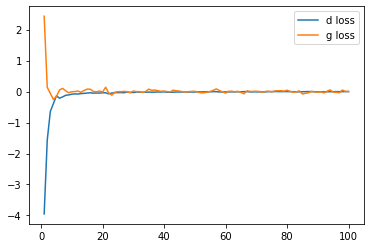

In [17]:
# Display losses for both the generator and discriminator
plt.figure()
plt.plot(range(1, num_epochs + 1), d_losses, label = 'd loss')
plt.plot(range(1, num_epochs + 1), g_losses, label = 'g loss')    
plt.legend()
plt.show()

In [42]:
# Generate a few fake samples (5 of them) for visualization
n_samples = 5
z = torch.randn(n_samples, latent_size).cuda()
z = Variable(z)
fake_images = G(z)
fake_images = fake_images.cpu().detach().numpy().reshape(n_samples, 28, 28)
print(fake_images.shape)

(5, 28, 28)


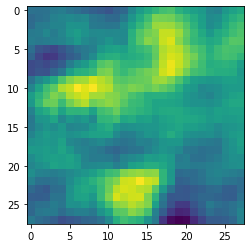

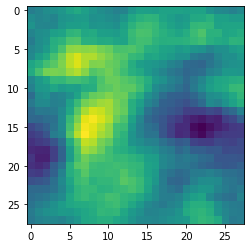

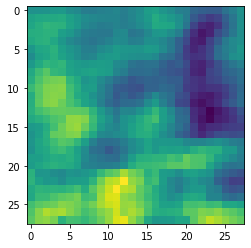

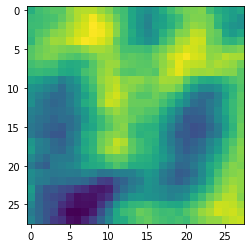

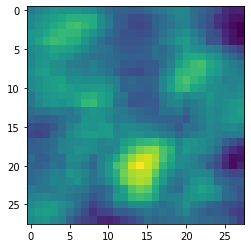

In [43]:
# Display
plt.figure()
plt.imshow(fake_images[0])
plt.show()
plt.figure()
plt.imshow(fake_images[1])
plt.show()
plt.figure()
plt.imshow(fake_images[2])
plt.show()
plt.figure()
plt.imshow(fake_images[3])
plt.show()
plt.figure()
plt.imshow(fake_images[4])
plt.show()

### Questions and expected answers for the report

1. Copy and paste the code for your Critic class. Briefly explain your choice of architecture.


2. Copy and paste the code for your Generator class. Briefly explain your choice of architecture.


3. For how many iterations did you have to train when using Wasserstein with Conv/TransposeConv layers to get plausible images from the generator? Is it training faster than the Fully Connected Wasserstein/Vanilla GAN?


4. Display some samples generated by your trained generator. Do they look plausible?


5. Let us assume we use Conv2d layers in the Critic. We do NOT use Transposed Conv2d layers, but only Fully Connected layers in the Generator. Would the GAN still be able to train both models or would it encounter difficulties? Discuss.

### 1. Copy and paste the code for your Critic class. Briefly explain your choice of architecture.

In [20]:
# Critic
class Critic(nn.Module):
    
    def __init__(self, image_size):
        """
        Only forced parameter will be the image size, set to 28.
        """
        super().__init__()
        self.image_size = image_size
        self.D = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride = 2, padding = 1),
            nn.Conv2d(16, 32, 3, stride = 2, padding = 1),
            nn.Conv2d(32, 64, 1, stride = 2, padding = 1)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(32*64*5*5, 32)
        )
        
    def forward(self, x):
        x = self.D(x)
        x = x.view(-1, 32*64*5*5)
        x = self.fc(x)
        x = x.view(-1, 1)
        return x


### 2. Copy and paste the code for your Generator class. Briefly explain your choice of architecture.


In [21]:
# Generator
class Generator(nn.Module):
    
    def __init__(self, latent_size, image_size):
        """
        Only forced parameters will be the image size, set to 28,
        and the latent size set to 64.
        """
        super().__init__()
        self.image_size = image_size
        self.latent_size = latent_size
        self.input_length = int(latent_size**0.5)
        self.fc = nn.Linear(latent_size, latent_size)
        self.G = nn.Sequential(
            nn.ConvTranspose2d(1, 4, 3,stride=1, padding=1),
            nn.ConvTranspose2d(4, 8, 3,stride=2, padding=1),
            nn.ConvTranspose2d(8, 1, 2,stride=2, padding=1)
        )
                
    def forward(self, x):
        x = x.view(-1, self.latent_size)
        x = self.fc(x)
        x = x.view(-1, 1, self.input_length, self.input_length)
        x = self.G(x)
        return x

### 3. For how many iterations did you have to train when using Wasserstein with Conv/TransposeConv layers to get plausible images from the generator? Is it training faster than the Fully Connected Wasserstein/Vanilla GAN?


I trained the generator for 100 epochs to get some plausible images.

No, the training is not faster than the Fully Connected Wasserstein/Vanilla GAN.

### 4. Display some samples generated by your trained generator. Do they look plausible?


Some of them are plausible, like the second image displayed below. It is obviously a diagonal "3".

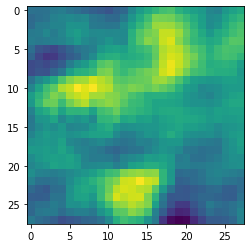

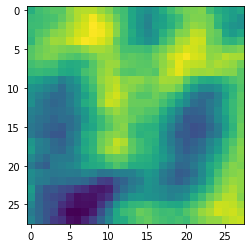

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [45]:
# Display
plt.figure()
plt.imshow(fake_images[0])
plt.show()
plt.figure()
plt.imshow(fake_images[3])
plt.show()
plt.figure()

### 5. Let us assume we use Conv2d layers in the Critic. We do NOT use Transposed Conv2d layers, but only Fully Connected layers in the Generator. Would the GAN still be able to train both models or would it encounter difficulties? Discuss.

The GAN would hypothetically still be able to train both models. 

However, it would encounter difficulties in training a generator (with fully connected layers) to generate images, let alone images to beat the critic. This is because of the nature of fully connected layers not having the efficiency to make features for a 2-dimensional space of the image like Transposed Conv2d layers do.

Given the generator's difficulty to generate images, this would in turn affect the critic's training to score real and fake images. Since it is difficult for the generator to generate fake images that are even close to being real, the critic would not be well-trained to be assign a score to fake images that are close to being real.

Given the sub-par training and hypothetical performance of the GAN in this case, the losses between the critic and generator is likely to converge even before the generator generates plausible images. Resulting in a generator that may not be able to generate good fake images at all.

Nevertheless, if the fully connected layers of the generator is initialised or designed well enough, I think it is possible for a GAN with a generator with fully connected layers to train both models well enough.